In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
from threading import Thread
import cv2
import os, sys
import time
import glob
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from itertools import chain, compress
from queue import Queue
from scipy.stats import chi2
import pytransform3d.transformations as pt
import pytransform3d.rotations as pr
from pytransform3d.plot_utils import make_3d_axis
from tqdm import tqdm

In [9]:
import os, sys
sys.path.append('..')

from config import *
from image_processing import *
from image_reader import *
from online_testing import *
from utils import *
from states import *
from feature import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
"""
Snapshot PnP VO solver
"""
class SnapshotPnPSolver(object):
    def __init__(self, config, verbose=True):
        self.config = config
        self.optimization_config = config.optimization_config
        self.map_server = dict()   # <FeatureID, Feature>
        self.state = None
        self.prev_state = CAMState()
        self.verbose = verbose

        self.K = self.to_K(config.cam0_intrinsics)
        self.T_cam_w = Isometry3d(config.T_cam0_imu[:3, :3], config.T_cam0_imu[:3, 3])

        CAMState.next_id = 0

        # Tracking rate.
        self.tracking_rate = None

        # Indicate if the received image is the first one. The system will 
        # start after receiving the first image.
        self.is_first_img = True

    def to_K(self, params):
        
        K = np.zeros((3,3))
        K[0, 0] = params[0]
        K[0, 2] = params[2]
        K[1, 1] = params[1]
        K[1, 2] = params[3]
        K[2, 2] = 1
        return K
    
    def feature_callback(self, feature_msg):
        """
        Callback function for feature measurements.
        """
        start = time.time()
        self.state = CAMState(CAMState.next_id)
        self.state.timestamp = feature_msg.timestamp
        
        t = time.time()

        # Add new observations for existing features or new features 
        # in the map server.
        self.add_feature_observations(feature_msg)

        if self.verbose:
            print('___add_feature_observations', time.time() - t)

        # Start the system if the first image is received.
        # The frame where the first image is received will be the origin.
        if self.is_first_img:
            self.is_first_img = False
            self.state.position = self.prev_state.position
            self.state.orientation = self.prev_state.orientation
        else:
            t = time.time()
            # Track state using visual odometry
            self.track_state(feature_msg)

            if self.verbose:
                print('___track_state', time.time() - t)
        if self.verbose:
            print('===snapshot PnP VO elapsed:          ', time.time() - start, f'({feature_msg.timestamp})')

        try:
            # Publish the odometry.
            return self.publish(feature_msg.timestamp)
        finally:
            # Reset the system if necessary.
            self.prev_state = self.state
            CAMState.next_id += 1

    def add_feature_observations(self, feature_msg):
        tracked_feature_num = 0
        curr_feature_num = len(self.map_server)
        for feature in feature_msg.features:
            if feature.id not in self.map_server:
                # This is a new feature.
                map_feature = Feature(feature.id, self.optimization_config)
                map_feature.observations[self.state.id] = np.array([
                    feature.u0, feature.v0])
                self.map_server[feature.id] = map_feature
            else:
                # This is an old feature.
                self.map_server[feature.id].observations[self.state.id] = np.array([
                    feature.u0, feature.v0])
                tracked_feature_num += 1

        self.tracking_rate = tracked_feature_num / (curr_feature_num+1e-5)

    def track_state(self, feature_msg):
        prev_id = self.prev_state.id
        curr_id = self.state.id

        prev_points = []
        curr_points = []
        for feature in feature_msg.features:
            map_feature = self.map_server[feature.id]
            if prev_id in map_feature.observations.keys():
                curr_points.append(map_feature.observations[curr_id])
                prev_points.append(map_feature.observations[prev_id])

        # print('Features for VO: ', list(zip(curr_points, prev_points)))

        prev_points = np.array(prev_points)
        curr_points = np.array(curr_points)

        # print('points shape ', prev_points.shape, curr_points.shape)

        R, T, _ = self.recover_pose(prev_points, curr_points)
        
        R_p_w = to_rotation(self.prev_state.orientation)
        T_p_w = self.prev_state.position

        H_p_w = Isometry3d(R_p_w, T_p_w)
#         H_c_p = Isometry3d(R, T)
#         print("Before ", R[:2, :2], T[:2])
        flip = np.array([
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, -1.0]
        ])
        H_c_p = Isometry3d(R, np.squeeze(T))
#         print("After")
#         print(T)
        # print("H_p_w ", H_p_w.R, H_p_w.t)
        # print("H_c_p ", H_c_p.R, H_c_p.t)

#         H_c_w = H_p_w * H_c_p
        print(H_c_p.t)
        H_c_w = H_c_p
        self.state.orientation = to_quaternion(H_c_w.R)
        self.state.position = H_c_w.t        

    def recover_pose(self, prev_points, curr_points, mask=None):
        E, mask = cv2.findEssentialMat(curr_points, prev_points, self.K, cv2.RANSAC, 0.9, 1.0, mask)
        
        _, R, T, mask = cv2.recoverPose(E, curr_points, prev_points, self.K, mask=mask)

        return R, T, mask
    
    def publish(self, time):
        state = self.state
        if self.verbose:
            print('+++publish:')
            print('   timestamp:', state.timestamp)
            print('   orientation:', state.orientation)
            print('   position:', state.position)
            print()
        
        H_c_w = Isometry3d(
            to_rotation(state.orientation),
            state.position)
        
        return namedtuple('vo_result', ['timestamp', 'pose'])(
            time, H_c_w)

In [23]:
class Trajectory(object):
    def __init__(self):
        self.times = []
        self.transforms = []
        self.max_s = np.zeros(3)
        self.min_s = np.zeros(3)
        
    def add_point(self, msg, origin="world"):
        if origin=="world":
            H_c_w = msg.pose
        elif origin=="cam":
            H_w_c = msg.pose
            H_c_w = H_w_c.inverse()
        self.times.append(msg.timestamp)
        self.transforms.append(H_c_w)
        t = H_c_w.t
        if len(self.times)==1 and (np.all(self.max_s==0) and np.all(self.min_s==0)):
            self.max_s = t.copy()
            self.min_s = t.copy()
        else:
            for j in range(3):
                self.max_s[j] = max(self.max_s[j], t[j]) 
                self.min_s[j] = min(self.min_s[j], t[j]) 
        
    def __len__(self):
        return len(self.times)

    def pytf_pose(self, num):
        r = self.transforms[num].R
        t = self.transforms[num].t
        r = pr.matrix_from_quaternion(pr.quaternion_from_matrix(r, strict_check=False))
        return r, t
    
    def create_plot(self, n=100000, mode="trajectory"):
        ax = make_3d_axis(ax_s=1, unit="m", n_ticks=6)

        scale = 1e-5 + max([i-j for i, j in zip(self.max_s, self.min_s)])/1.5
        center = [(i+j)/2.0 for i, j in zip(self.max_s, self.min_s)]

        ax.set_xlim((center[0]-scale, center[0]+scale))
        ax.set_ylim((center[1]-scale, center[1]+scale))
        ax.set_zlim((center[2]-scale, center[2]+scale))

#         ax.view_init(azim=0, elev=90)
        
        last_n = min(len(self.times), n)
        t0 = self.transforms[0].t
        ax.scatter(t0[0], t0[1], t0[2], s=100, marker='o', color="lightgreen")
        tn = self.transforms[last_n-1].t
        ax.scatter(tn[0], tn[1], tn[2], s=100, marker='o', color="lightsalmon")
        if mode=="trajectory":
            t_x, t_y, t_z = [], [], []
            for num in tqdm(range(last_n)):
                t = self.transforms[num].t
                t_x.append(t[0])
                t_y.append(t[1])
                t_z.append(t[2])
            ax.scatter(t_x, t_y, t_z, s=0.1, color="gray")
        elif mode=="poses":
            for num in tqdm(range(last_n)):
                r, t = self.pytf_pose(num)
                pt.plot_transform(ax=ax, A2B=pt.transform_from(r, t))
        plt.tight_layout()

In [24]:
def ground_truth_load(times, file='/content/00.txt', start_idx=0):
    traj = Trajectory()
    with open(file) as f:
        lines = f.readlines()
        for i in tqdm(range(start_idx, min(len(times), len(lines)))):
            tmp44 = np.array(lines[i].rstrip().split(" ")[1:], dtype=np.float64).reshape((4, 4))
            H_curr = Isometry3d(tmp44[:3, :3], tmp44[:3, 3])
            timestamp = times[i]
            # print(timestamp, ' : ', H_curr)
            msg = namedtuple('ground_truth', ['timestamp', 'pose'])(
                    timestamp, H_curr)
            traj.add_point(msg, origin="world")
    return traj

In [25]:
# Pretty printing
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [26]:
# Paths
start_idx = 0
ids = sorted(glob.glob("/scratch/users/shubhgup/Left/*.png"))
ids = ids[start_idx:]
now = time.time()
timestamps = now + 0.03*np.arange(0, len(ids))
assert(len(ids) == len(timestamps))

In [27]:
cam0 = MonoCamera(ImageReader(ids, timestamps))
cam0.set_starttime(now)
img_queue = Queue()
img_publisher = DataPublisher(
        cam0, img_queue)

In [28]:
ip = ImageProcessor(ConfigHKMedUrban(), verbose=False)
solver = SnapshotPnPSolver(ConfigHKMedUrban(), verbose=False)
traj = Trajectory()

In [ ]:
gt_traj = ground_truth_load(timestamps, file="/oak/stanford/groups/gracegao/KITTI360/data_poses/2013_05_28_drive_0000_sync/cam0_to_world.txt", start_idx=start_idx)
solver.prev_state.position = gt_traj.transforms[0].t
solver.prev_state.orientation = to_quaternion(gt_traj.transforms[0].R)
traj.max_s = gt_traj.max_s.copy()
traj.min_s = gt_traj.min_s.copy()

In [ ]:
gt_traj.create_plot(n=5000)

In [29]:
img_publisher.start(now)

In [30]:
try:
    for i in tqdm(range(5000)):
        msg = img_queue.get()
        if msg is None:
            break
        meas = ip.camera_callback(msg)
        odom = solver.feature_callback(meas)
        traj.add_point(odom)
except Exception as e:
    print(e)
img_publisher.stop()

  0%|          | 15/5000 [00:00<01:09, 72.06it/s]

[0.34 -0.03 -0.94]
[1.00 -0.02 0.06]
[0.91 0.21 -0.36]
[0.83 -0.52 0.19]
[0.31 -0.91 -0.26]
[0.92 0.37 0.12]
[-0.39 0.01 -0.92]
[1.00 0.06 0.00]
[0.79 -0.56 0.25]
[0.77 -0.47 -0.43]
[0.89 0.26 0.38]
[0.09 -0.97 -0.21]
[0.37 -0.88 -0.29]
[0.36 -0.89 -0.30]
[0.35 -0.89 -0.30]


  0%|          | 23/5000 [00:00<01:22, 60.65it/s]

[0.35 -0.89 -0.29]
[0.81 0.56 0.14]
[0.32 -0.90 -0.29]
[0.39 -0.87 -0.30]
[-0.51 -0.66 0.55]
[0.34 -0.89 -0.29]
[0.36 -0.89 -0.27]
[0.75 -0.57 -0.33]
[0.17 -0.38 0.91]
[0.15 -0.46 0.87]
[0.90 0.34 0.28]


  1%|          | 36/5000 [00:00<01:30, 55.04it/s]

[0.43 -0.89 0.18]
[0.26 -0.93 -0.24]
[0.06 -0.90 0.42]
[0.71 -0.49 -0.50]
[0.34 -0.89 -0.29]
[0.30 -0.91 -0.27]
[0.37 -0.35 0.86]
[-0.03 -0.88 0.47]
[0.36 -0.92 0.17]
[0.02 -0.51 0.86]


  1%|          | 48/5000 [00:00<01:34, 52.33it/s]

[-0.22 -0.41 0.88]
[0.98 0.12 -0.14]
[-0.50 -0.25 0.83]
[0.86 -0.42 -0.29]
[0.35 -0.88 -0.31]
[-0.30 -0.58 0.76]
[0.90 0.27 0.33]
[0.91 -0.32 0.26]
[0.92 0.22 0.33]
[0.35 -0.89 -0.30]
[0.43 -0.88 -0.21]


  1%|          | 54/5000 [00:00<01:33, 52.97it/s]

[0.88 0.20 0.44]
[0.35 -0.89 -0.29]
[0.90 -0.34 0.28]
[0.22 -0.90 -0.38]
[0.30 -0.91 -0.29]
[0.35 -0.89 -0.29]
[-0.47 -0.27 0.84]
[0.34 -0.90 -0.29]
[0.34 -0.90 -0.28]
[0.33 -0.90 -0.29]
[0.90 0.26 0.35]


  1%|▏         | 66/5000 [00:01<01:32, 53.47it/s]

[0.35 -0.89 -0.30]
[-0.09 -0.14 0.99]
[-0.34 -0.17 0.93]
[-0.24 -0.18 0.95]
[0.27 -0.54 0.80]
[0.25 -0.90 -0.35]
[0.31 0.09 0.95]
[0.34 -0.90 -0.28]
[0.88 0.20 0.44]
[0.20 -0.28 0.94]
[0.34 -0.90 -0.28]
[0.93 -0.07 0.37]


  2%|▏         | 80/5000 [00:01<01:21, 60.09it/s]

[0.94 0.26 0.23]
[0.97 0.26 -0.04]
[-0.20 -0.25 0.95]
[0.07 -0.97 -0.25]
[0.91 0.23 0.33]
[-0.25 -0.17 0.95]
[0.88 0.22 0.42]
[0.07 -0.97 -0.24]
[0.59 -0.79 -0.18]
[0.30 -0.91 -0.28]
[0.17 -0.57 0.81]
[0.55 -0.78 -0.31]
[0.37 0.16 0.91]
[0.98 0.16 -0.09]


  2%|▏         | 94/5000 [00:01<01:16, 64.43it/s]

[-0.23 -0.24 0.94]
[0.90 0.23 0.37]
[0.45 0.12 0.88]
[0.80 0.54 0.27]
[-0.36 -0.22 0.91]
[0.94 0.30 0.15]
[0.35 -0.11 0.93]
[0.97 -0.20 0.14]
[-0.16 0.04 0.99]
[-0.39 -0.16 -0.91]
[0.46 -0.16 0.87]
[0.57 0.43 -0.70]
[-0.26 -0.93 -0.25]
[-0.22 -0.05 -0.97]


  2%|▏         | 108/5000 [00:01<01:13, 66.24it/s]

[-0.13 -0.14 0.98]
[-0.16 -0.00 0.99]
[-0.04 0.02 -1.00]
[0.32 0.17 0.93]
[-0.06 -0.17 0.98]
[0.34 -0.11 0.93]
[0.32 -0.09 0.94]
[0.51 0.22 0.83]
[-0.13 -0.05 -0.99]
[-0.06 -0.01 1.00]
[-0.25 -0.10 0.96]
[0.26 0.12 0.96]
[0.23 0.11 0.97]
[-0.04 -0.14 0.99]


  2%|▏         | 122/5000 [00:02<01:12, 66.83it/s]

[-0.32 0.04 0.95]
[0.15 0.06 0.99]
[0.08 0.12 0.99]
[0.26 0.01 0.97]
[0.13 0.04 0.99]
[-0.19 0.10 0.98]
[0.04 0.01 1.00]
[0.18 0.09 0.98]
[-0.44 -0.26 0.86]
[0.08 -0.00 1.00]
[-0.11 -0.01 0.99]
[-0.16 -0.05 0.99]
[0.11 0.05 0.99]
[0.17 0.06 0.98]


  3%|▎         | 136/5000 [00:02<01:15, 64.67it/s]

[0.24 0.13 0.96]
[0.01 0.16 0.99]
[-0.02 -0.04 1.00]
[-0.30 -0.14 0.95]
[-0.23 0.04 0.97]
[0.28 0.07 0.96]
[-0.09 0.02 1.00]
[0.37 -0.09 0.93]
[0.14 0.03 0.99]
[-0.31 -0.05 0.95]
[-0.10 0.05 0.99]
[-0.08 -0.02 1.00]
[-0.15 0.14 0.98]


  3%|▎         | 149/5000 [00:02<01:30, 53.36it/s]

[-0.04 0.03 1.00]
[0.12 0.10 0.99]
[-0.24 -0.21 0.95]
[0.03 0.03 1.00]
[0.14 0.06 0.99]
[-0.03 -0.06 1.00]
[0.00 -0.01 1.00]
[-0.17 -0.07 0.98]
[0.14 0.03 0.99]


  3%|▎         | 155/5000 [00:02<01:38, 49.17it/s]

[0.22 0.05 0.98]
[0.14 -0.01 0.99]
[0.11 0.06 0.99]
[0.32 0.06 0.95]
[0.21 0.08 0.97]
[0.02 -0.02 1.00]
[-0.01 -0.02 1.00]
[0.99 0.13 -0.06]


  3%|▎         | 161/5000 [00:02<01:51, 43.55it/s]

[-0.02 0.06 1.00]
[0.03 0.04 1.00]
[-0.23 0.13 0.97]
[0.22 -0.13 0.97]
[-0.10 -0.03 0.99]
[0.17 0.01 0.99]
[-0.08 0.00 1.00]
[-0.06 0.02 1.00]


  3%|▎         | 171/5000 [00:03<01:53, 42.70it/s]

[-0.07 -0.07 1.00]
[-0.49 0.07 0.87]
[-0.28 0.14 0.95]
[-0.60 -0.09 0.80]
[-0.32 0.10 0.94]
[-0.61 0.01 0.79]
[-0.46 -0.06 0.88]
[-0.54 0.05 0.84]
[-0.83 0.03 0.56]
[-0.83 0.01 0.56]


  4%|▎         | 181/5000 [00:03<01:46, 45.46it/s]

[-0.36 0.24 0.90]
[-0.60 0.44 0.67]
[0.23 0.54 0.81]
[0.04 0.48 0.88]
[0.38 0.53 0.76]
[0.41 -0.25 -0.88]
[-0.87 0.19 0.45]
[-0.90 0.12 0.42]
[-0.98 0.14 0.11]


  4%|▍         | 191/5000 [00:03<01:52, 42.69it/s]

[-0.24 0.02 0.97]
[0.35 0.41 0.84]
[-0.85 0.11 0.51]
[-0.08 0.23 0.97]
[-0.96 0.12 0.24]
[-0.82 0.02 0.57]
[0.08 0.38 0.92]
[0.15 0.43 0.89]
[-0.95 0.11 0.29]


  4%|▍         | 201/5000 [00:03<01:55, 41.46it/s]

[0.07 0.33 0.94]
[0.59 -0.08 0.80]
[0.01 0.45 0.89]
[-0.03 0.43 0.90]
[0.52 0.52 0.68]
[0.65 0.50 0.57]
[-0.13 0.01 0.99]
[-0.16 -0.05 0.99]


  4%|▍         | 206/5000 [00:03<02:04, 38.62it/s]

[-0.17 0.09 0.98]
[-0.00 0.47 0.88]
[-0.99 0.04 -0.09]
[-0.97 -0.01 0.22]
[-0.98 0.05 -0.21]
[-0.98 0.03 -0.19]
[-0.95 0.07 -0.30]
[-0.99 -0.02 0.16]


  4%|▍         | 214/5000 [00:04<02:05, 38.01it/s]

[-1.00 -0.02 0.04]
[-0.92 -0.07 0.38]
[-0.80 0.01 0.60]
[-0.48 0.09 0.87]
[-0.73 -0.03 0.69]
[-0.44 0.02 0.90]
[-0.36 0.04 0.93]
[-0.28 0.10 0.96]


  4%|▍         | 223/5000 [00:04<02:22, 33.51it/s]

[-0.14 -0.02 0.99]
[-0.17 0.04 0.98]
[-0.07 0.00 1.00]
[-0.17 0.11 0.98]
[-0.07 -0.02 1.00]
[-0.02 0.01 1.00]


  5%|▍         | 235/5000 [00:04<01:48, 43.82it/s]

[-0.14 -0.02 0.99]
[0.13 0.03 0.99]
[-0.02 -0.03 1.00]
[0.10 -0.00 1.00]
[0.10 0.03 0.99]
[0.36 0.06 0.93]
[0.07 -0.08 0.99]
[0.09 -0.01 1.00]
[0.17 0.02 0.99]
[0.10 0.01 0.99]
[0.07 -0.03 1.00]
[0.31 -0.06 0.95]


  5%|▍         | 249/5000 [00:04<01:28, 53.77it/s]

[-0.03 -0.09 1.00]
[0.12 0.03 0.99]
[-0.05 0.07 1.00]
[0.07 -0.14 0.99]
[0.16 0.04 0.99]
[0.59 0.04 0.81]
[0.82 -0.02 0.58]
[0.02 0.05 1.00]
[0.17 -0.03 0.99]
[0.63 -0.09 0.77]
[-1.00 -0.00 0.05]
[-0.10 0.02 0.99]
[0.04 0.01 1.00]
[0.08 0.05 1.00]


  5%|▌         | 256/5000 [00:05<01:23, 56.77it/s]

[0.60 0.04 0.80]
[0.06 0.01 1.00]
[0.28 -0.01 0.96]
[0.16 -0.02 0.99]
[0.06 0.01 1.00]
[-0.03 0.05 1.00]
[-0.07 -0.02 1.00]
[0.28 -0.02 0.96]
[0.06 0.06 1.00]
[0.07 0.04 1.00]
[-0.02 -0.02 1.00]
[-0.06 0.05 1.00]
[0.05 -0.01 1.00]
[0.09 0.03 1.00]


  5%|▌         | 272/5000 [00:05<01:15, 62.80it/s]

[0.18 -0.04 0.98]
[-0.02 -0.03 1.00]
[0.22 0.03 0.97]
[0.07 0.07 1.00]
[-0.00 0.03 1.00]
[-0.05 -0.00 1.00]
[0.02 -0.02 1.00]
[-0.02 0.02 1.00]
[-0.20 -0.02 0.98]
[0.17 -0.11 0.98]
[0.00 0.03 1.00]
[0.20 0.10 0.97]
[0.03 0.01 1.00]
[-0.02 0.05 1.00]


  6%|▌         | 286/5000 [00:05<01:23, 56.54it/s]

[0.05 -0.04 1.00]
[-0.60 -0.26 0.76]
[-0.45 -0.02 0.90]
[-0.05 0.06 1.00]
[-0.00 0.07 1.00]
[0.05 0.12 0.99]
[-0.02 -0.01 1.00]
[0.04 0.01 1.00]
[-0.03 0.07 1.00]
[0.09 -0.11 0.99]


  6%|▌         | 292/5000 [00:05<01:27, 53.64it/s]

[0.09 -0.03 1.00]
[-0.08 -0.02 1.00]
[0.04 -0.07 1.00]
[0.10 0.03 0.99]
[-0.42 0.03 0.91]
[0.08 -0.03 1.00]
[0.02 0.00 1.00]
[0.01 0.02 1.00]
[0.10 0.03 0.99]


  6%|▌         | 304/5000 [00:05<01:41, 46.45it/s]

[0.07 -0.02 1.00]
[0.00 -0.03 1.00]
[0.09 0.05 0.99]
[0.18 0.07 0.98]
[-0.05 -0.05 1.00]
[-0.08 -0.17 0.98]
[-0.03 0.02 1.00]
[-0.00 0.04 1.00]
[-0.05 0.07 1.00]


  6%|▋         | 314/5000 [00:06<01:43, 45.10it/s]

[0.23 -0.05 0.97]
[0.05 -0.07 1.00]
[0.01 -0.01 1.00]
[-0.06 -0.06 1.00]
[0.02 -0.02 1.00]
[0.04 -0.00 1.00]
[0.06 -0.05 1.00]
[-0.10 0.02 0.99]
[-0.04 0.06 1.00]


  7%|▋         | 328/5000 [00:06<01:27, 53.60it/s]

[-0.07 -0.05 1.00]
[-0.02 -0.02 1.00]
[0.02 0.00 1.00]
[-0.00 -0.00 1.00]
[0.07 0.00 1.00]
[0.10 -0.04 0.99]
[-0.02 0.01 1.00]
[0.05 0.01 1.00]
[-0.01 -0.04 1.00]
[0.04 -0.07 1.00]
[-0.36 -0.15 0.92]
[-0.01 0.06 1.00]
[0.04 0.01 1.00]
[0.30 0.05 0.95]


  7%|▋         | 336/5000 [00:06<01:18, 59.61it/s]

[0.02 -0.08 1.00]
[-0.03 -0.04 1.00]
[0.10 -0.02 0.99]
[0.18 0.08 0.98]
[0.08 0.15 0.99]
[-0.10 0.06 0.99]
[0.06 -0.04 1.00]
[0.15 -0.00 0.99]
[0.08 0.04 1.00]
[0.06 -0.01 1.00]
[0.19 -0.13 0.97]
[0.12 -0.01 0.99]


  7%|▋         | 343/5000 [00:06<01:39, 46.74it/s]

[-0.05 0.05 1.00]
[0.03 -0.02 1.00]
[0.19 0.02 0.98]
[0.06 0.09 0.99]
[0.07 -0.01 1.00]
[0.07 0.06 1.00]
[0.01 -0.00 1.00]


  7%|▋         | 354/5000 [00:07<01:53, 41.10it/s]

[0.15 -0.08 0.99]
[0.19 0.05 0.98]
[0.05 0.04 1.00]
[-0.02 0.01 1.00]
[0.15 0.07 0.99]
[0.13 0.00 0.99]
[0.10 -0.00 0.99]
[0.08 -0.10 0.99]


  7%|▋         | 369/5000 [00:07<01:26, 53.47it/s]

[0.14 -0.04 0.99]
[0.19 0.12 0.97]
[0.16 0.01 0.99]
[0.02 0.01 1.00]
[0.05 -0.12 0.99]
[-0.03 -0.03 1.00]
[0.30 0.06 0.95]
[0.33 -0.27 0.91]
[-0.01 0.04 1.00]
[0.09 -0.05 0.99]
[-0.09 -0.04 1.00]
[0.02 -0.02 1.00]
[0.16 0.00 0.99]
[0.05 0.03 1.00]
[0.00 -0.00 1.00]


  8%|▊         | 384/5000 [00:07<01:15, 61.46it/s]

[0.15 0.01 0.99]
[-0.01 0.03 1.00]
[-0.02 0.07 1.00]
[0.07 -0.03 1.00]
[0.05 -0.12 0.99]
[0.06 -0.07 1.00]
[0.13 -0.03 0.99]
[-0.02 0.02 1.00]
[0.02 0.02 1.00]
[0.05 -0.02 1.00]
[0.12 0.03 0.99]
[0.11 -0.01 0.99]
[0.15 -0.04 0.99]
[0.16 0.02 0.99]
[0.02 0.03 1.00]


  8%|▊         | 391/5000 [00:07<01:15, 60.73it/s]

[0.07 -0.00 1.00]
[0.06 -0.01 1.00]
[0.04 -0.02 1.00]
[-0.00 0.02 1.00]
[0.16 -0.03 0.99]
[0.22 -0.13 0.97]
[0.06 0.03 1.00]
[0.08 -0.00 1.00]
[0.05 0.07 1.00]
[0.28 -0.01 0.96]


  8%|▊         | 404/5000 [00:07<01:21, 56.06it/s]

[-0.06 -0.01 1.00]
[0.07 -0.04 1.00]
[0.11 -0.02 0.99]
[0.23 -0.09 0.97]
[0.05 -0.07 1.00]
[0.11 -0.03 0.99]
[-0.12 -0.01 0.99]
[0.08 0.00 1.00]
[-0.15 -0.06 0.99]
[0.02 0.03 1.00]
[0.06 -0.04 1.00]
[-0.14 0.06 0.99]
[-0.02 0.02 1.00]


  8%|▊         | 420/5000 [00:08<01:07, 67.65it/s]

[0.10 0.13 0.99]
[0.03 0.02 1.00]
[0.07 0.03 1.00]
[0.07 -0.01 1.00]
[0.08 0.03 1.00]
[0.08 0.01 1.00]
[0.14 -0.09 0.99]
[0.19 -0.12 0.97]
[0.04 0.06 1.00]
[-0.01 0.04 1.00]
[0.07 -0.08 0.99]
[0.08 -0.01 1.00]
[0.20 -0.03 0.98]
[-0.01 -0.03 1.00]
[0.07 -0.04 1.00]
[0.02 0.00 1.00]
[-0.01 0.07 1.00]
[-0.23 0.05 0.97]
[0.02 0.12 0.99]


  9%|▊         | 430/5000 [00:08<01:01, 74.85it/s]

[0.19 -0.06 0.98]
[0.33 0.01 0.94]
[0.17 0.01 0.98]
[0.04 -0.05 1.00]
[0.02 0.04 1.00]
[0.01 0.10 0.99]
[-0.09 -0.07 0.99]

  9%|▉         | 445/5000 [00:08<01:21, 55.89it/s]


[-0.15 -0.05 0.99]
[0.01 0.01 1.00]
[-0.09 0.09 0.99]
[0.18 0.01 0.98]
[0.21 0.02 0.98]
[-0.02 -0.24 0.97]
[-0.23 -0.28 0.93]
[0.61 0.06 0.79]
[-0.12 0.30 0.94]
[0.46 0.02 -0.89]
[-0.51 -0.83 0.22]
[-0.25 0.03 0.97]


  9%|▉         | 460/5000 [00:08<01:12, 62.52it/s]

[-0.55 -0.17 0.82]
[0.69 0.58 -0.44]
[0.49 -0.52 -0.70]
[0.79 0.49 -0.37]
[-0.08 -0.28 0.96]
[-0.14 -0.09 0.99]
[-0.64 -0.07 0.76]
[-0.59 -0.22 0.78]
[0.17 0.57 0.80]
[-0.42 -0.67 -0.61]
[0.67 0.22 0.71]
[0.01 0.33 0.94]
[0.87 0.32 0.38]
[0.60 -0.57 0.56]
[0.32 0.49 0.81]


 10%|▉         | 478/5000 [00:08<01:00, 75.07it/s]

[0.21 0.63 0.75]
[0.69 0.59 0.41]
[0.11 -0.99 0.04]
[0.51 -0.67 -0.54]
[0.53 -0.50 -0.68]
[0.93 -0.13 -0.35]
[0.98 -0.21 0.01]
[0.65 0.26 0.71]
[-0.53 -0.57 -0.63]
[0.09 -0.92 0.38]
[0.17 0.42 0.89]
[0.57 -0.52 0.64]
[0.47 -0.88 -0.03]
[-0.66 -0.72 -0.19]
[-0.46 -0.65 -0.60]
[0.28 -0.86 -0.43]
[0.58 -0.57 0.58]
[0.86 0.39 0.34]
[-0.00 0.64 0.77]


 10%|▉         | 498/5000 [00:09<00:54, 83.28it/s]

[0.93 -0.32 -0.19]
[0.81 -0.24 -0.54]
[-0.41 -0.56 0.72]
[0.55 0.14 0.82]
[0.40 -0.66 -0.64]
[0.01 -0.65 0.76]
[-0.44 0.08 0.89]
[0.73 -0.30 -0.61]
[0.91 0.13 -0.40]
[0.88 -0.32 -0.34]
[0.93 -0.34 -0.17]
[0.95 -0.29 -0.13]
[0.81 -0.32 -0.49]
[0.79 -0.28 -0.55]
[0.73 -0.32 -0.60]
[0.74 -0.31 -0.59]
[0.72 -0.66 -0.23]
[0.57 -0.65 -0.50]


 10%|█         | 516/5000 [00:09<00:52, 84.99it/s]

[-0.26 -0.45 0.85]
[0.78 -0.29 -0.56]
[0.60 -0.47 0.65]
[0.74 -0.31 -0.60]
[0.80 -0.10 0.59]
[0.62 0.23 0.75]
[0.80 -0.23 -0.56]
[0.86 -0.21 -0.46]
[0.68 -0.72 0.17]
[0.24 0.32 0.91]
[0.70 -0.71 0.08]
[0.79 -0.35 -0.50]
[0.59 -0.56 0.58]
[-0.58 0.16 0.80]
[0.77 -0.56 -0.32]
[0.76 -0.05 0.64]
[0.88 0.02 0.48]
[0.74 -0.32 -0.59]


 10%|█         | 525/5000 [00:09<00:52, 85.04it/s]

[0.75 -0.07 0.66]
[0.94 -0.31 -0.13]
[0.84 -0.35 -0.42]
[0.76 -0.26 -0.60]
[0.95 -0.32 -0.02]
[-0.35 0.26 0.90]
[-0.75 0.30 0.59]
[0.77 -0.33 -0.54]
[0.98 -0.18 0.03]
[0.95 0.13 0.27]
[0.84 0.25 -0.48]
[0.81 -0.35 -0.47]
[0.79 -0.62 0.02]
[0.81 -0.14 0.57]


 11%|█         | 534/5000 [00:09<01:05, 68.33it/s]

[-0.50 -0.75 0.44]
[0.77 -0.26 -0.58]
[0.73 -0.30 -0.61]
[0.80 -0.21 -0.56]
[0.93 -0.27 -0.25]
[-0.50 -0.82 0.28]
[0.70 0.24 0.67]


 11%|█         | 542/5000 [00:09<01:23, 53.24it/s]

[-0.28 0.34 0.90]
[0.75 -0.37 -0.55]
[-0.50 -0.03 0.86]
[0.92 0.11 0.38]
[0.93 -0.33 -0.15]
[0.76 -0.36 -0.54]
[0.96 -0.29 0.02]
[0.99 -0.17 -0.01]


 11%|█         | 549/5000 [00:10<01:35, 46.61it/s]

[-0.45 -0.08 0.89]
[0.81 0.53 0.25]
[0.67 0.19 0.72]
[0.92 -0.32 -0.23]
[-0.26 0.01 0.97]
[0.70 -0.47 -0.54]
[-0.60 0.17 0.78]


 11%|█         | 555/5000 [00:10<01:44, 42.63it/s]

[0.54 0.49 0.69]
[0.44 -0.70 0.56]
[0.79 -0.29 -0.54]
[0.83 -0.23 -0.51]
[0.85 -0.02 -0.52]
[0.89 -0.43 -0.16]
[-0.54 -0.26 0.80]


 11%|█▏        | 565/5000 [00:10<01:55, 38.48it/s]

[0.79 -0.26 -0.55]
[0.80 -0.27 -0.54]
[0.39 -0.36 0.85]
[0.80 -0.15 0.58]
[-0.03 0.03 1.00]
[0.82 -0.22 -0.53]
[0.94 -0.31 -0.12]


 11%|█▏        | 570/5000 [00:10<01:59, 37.05it/s]

[-0.36 -0.70 -0.62]
[0.97 -0.24 -0.01]
[0.02 -0.76 -0.64]
[0.91 -0.35 -0.23]
[0.35 -0.64 0.69]
[0.94 -0.16 0.29]
[0.72 -0.41 -0.56]


 12%|█▏        | 578/5000 [00:10<02:05, 35.25it/s]

[0.74 -0.57 -0.36]
[-0.41 -0.16 0.90]
[0.94 -0.22 -0.25]
[0.77 -0.33 -0.54]
[0.84 0.16 0.52]
[0.79 -0.33 -0.51]
[-0.21 0.46 0.86]


 12%|█▏        | 586/5000 [00:11<02:08, 34.31it/s]

[0.86 0.21 0.46]
[0.75 -0.31 -0.59]
[0.60 0.34 0.73]
[-0.33 -0.55 0.76]
[0.76 0.09 0.64]
[0.86 -0.48 -0.17]
[0.69 -0.68 -0.25]


 12%|█▏        | 594/5000 [00:11<02:10, 33.74it/s]

[0.84 -0.13 -0.53]
[-0.92 0.36 0.17]
[0.75 -0.62 0.22]
[0.78 -0.41 -0.47]
[-0.45 -0.78 0.44]
[0.10 -0.74 0.67]
[0.77 -0.38 -0.51]
[0.75 -0.33 -0.57]

 12%|█▏        | 598/5000 [00:11<02:09, 33.90it/s]


[0.63 -0.49 -0.60]
[0.86 0.50 -0.03]
[-0.33 0.02 0.94]
[0.93 -0.33 -0.16]
[-0.77 0.29 0.58]
[-0.30 0.04 0.95]


 12%|█▏        | 606/5000 [00:11<02:10, 33.62it/s]

[-0.74 0.38 0.56]
[0.81 -0.30 -0.51]
[0.88 -0.10 -0.47]
[-0.47 0.06 0.88]
[0.80 -0.26 -0.54]
[0.92 -0.33 -0.20]
[0.86 -0.22 -0.46]


 12%|█▏        | 614/5000 [00:12<02:12, 33.16it/s]

[0.88 -0.35 0.33]
[0.65 -0.66 -0.38]
[0.85 -0.52 -0.01]
[0.79 -0.38 -0.49]
[0.78 -0.32 -0.54]
[0.87 -0.50 -0.05]
[-0.36 -0.91 0.21]


 12%|█▏        | 622/5000 [00:12<02:13, 32.69it/s]

[-0.49 0.09 0.87]
[0.98 -0.18 0.03]
[0.64 0.34 0.69]
[0.94 -0.26 -0.21]
[0.72 0.09 0.69]
[0.92 -0.31 -0.23]
[0.93 0.36 0.04]


 13%|█▎        | 626/5000 [00:12<02:12, 32.89it/s]

[0.79 -0.40 -0.47]
[0.87 0.47 0.15]
[-0.20 -0.77 0.61]
[0.94 -0.33 -0.11]
[0.94 -0.21 0.28]
[0.77 -0.37 -0.52]
[0.85 -0.16 -0.50]


 13%|█▎        | 634/5000 [00:12<02:10, 33.36it/s]

[0.95 -0.28 -0.14]
[0.72 -0.46 -0.52]
[-0.78 0.29 0.56]
[0.84 -0.28 -0.46]
[-0.53 -0.56 -0.64]
[0.81 -0.37 0.45]
[0.75 -0.33 -0.58]


 13%|█▎        | 642/5000 [00:12<02:12, 32.82it/s]

[0.71 -0.43 -0.56]
[0.98 0.13 0.14]
[0.78 -0.32 -0.54]
[0.15 -0.93 0.32]
[0.97 -0.25 0.01]
[0.89 -0.17 0.42]
[0.55 0.46 0.70]


 13%|█▎        | 650/5000 [00:13<02:10, 33.36it/s]

[0.59 -0.69 -0.41]
[0.78 -0.05 0.63]
[-0.01 0.07 1.00]
[0.69 0.64 -0.35]
[-0.49 0.22 0.84]
[0.69 0.19 0.70]
[0.25 0.66 0.71]


 13%|█▎        | 654/5000 [00:13<02:09, 33.56it/s]

[0.33 -0.75 0.58]
[0.82 -0.54 0.17]
[0.94 -0.28 -0.22]
[0.54 0.48 0.69]
[0.76 -0.37 -0.53]
[-0.72 0.30 0.62]
[-0.70 -0.71 0.11]


 13%|█▎        | 662/5000 [00:13<02:09, 33.48it/s]

[0.99 0.05 0.16]
[0.74 -0.12 0.66]
[0.83 -0.44 0.35]
[0.40 0.51 0.76]
[0.90 0.32 -0.31]
[0.63 0.26 0.73]
[0.94 -0.07 0.34]


 13%|█▎        | 670/5000 [00:13<02:09, 33.51it/s]

[0.94 -0.29 -0.16]
[-0.74 -0.05 -0.67]
[0.48 -0.60 0.64]
[0.94 -0.08 0.32]
[-0.31 0.11 0.94]
[0.07 -0.79 -0.61]
[0.87 -0.48 -0.08]


 14%|█▎        | 678/5000 [00:13<02:11, 32.94it/s]

[0.66 0.57 -0.48]
[0.79 -0.43 -0.43]
[0.93 -0.37 -0.05]
[0.45 0.52 0.72]
[0.85 -0.15 -0.50]
[-0.50 0.09 0.86]
[0.99 0.01 -0.12]


 14%|█▎        | 682/5000 [00:14<02:10, 33.19it/s]

[0.86 -0.33 -0.38]
[-0.42 0.25 0.87]
[0.57 0.42 0.70]
[-0.50 0.07 0.86]
[0.90 -0.42 0.14]
[0.84 -0.24 -0.48]
[0.65 -0.29 0.71]


 14%|█▍        | 690/5000 [00:14<02:10, 32.92it/s]

[-0.43 -0.89 -0.17]
[-0.40 0.11 0.91]
[0.78 -0.30 -0.55]
[0.96 -0.28 -0.08]
[0.86 -0.34 -0.38]
[0.87 -0.38 -0.32]
[0.91 -0.35 -0.24]


 14%|█▍        | 698/5000 [00:14<02:09, 33.30it/s]

[0.90 -0.30 -0.31]
[-0.76 0.31 0.57]
[0.62 -0.67 0.40]
[0.99 -0.09 -0.12]
[0.57 -0.01 0.82]
[0.77 -0.31 -0.55]
[0.77 -0.51 -0.39]


 14%|█▍        | 706/5000 [00:14<02:09, 33.15it/s]

[0.53 -0.85 -0.03]
[-0.44 -0.86 0.27]
[0.77 -0.32 -0.55]
[0.66 -0.68 0.33]
[0.89 -0.45 -0.08]
[0.79 -0.34 -0.51]
[0.57 0.53 0.63]


 14%|█▍        | 710/5000 [00:14<02:10, 32.91it/s]

[0.92 -0.08 0.39]
[-0.28 0.18 0.94]
[0.93 -0.31 -0.22]
[-0.06 0.17 0.98]
[0.75 -0.35 -0.56]
[0.89 -0.44 -0.11]
[-0.51 0.11 0.85]


 14%|█▍        | 718/5000 [00:15<02:07, 33.58it/s]

[0.93 -0.34 -0.17]
[-0.46 0.07 0.88]
[0.64 -0.64 -0.42]
[0.21 0.56 0.80]
[1.00 -0.03 0.01]
[0.46 -0.06 0.88]
[0.43 0.54 0.72]


 15%|█▍        | 726/5000 [00:15<02:11, 32.44it/s]

[0.75 -0.31 -0.59]
[0.85 -0.41 -0.33]
[0.87 -0.36 -0.34]
[0.69 -0.41 -0.60]
[0.92 -0.30 -0.24]
[0.76 -0.29 -0.58]
[0.59 -0.47 -0.66]


 15%|█▍        | 734/5000 [00:15<02:06, 33.74it/s]

[0.74 -0.26 -0.62]
[0.63 0.36 0.69]
[0.75 -0.32 -0.58]
[0.70 -0.43 -0.57]
[0.76 -0.50 -0.42]
[0.74 -0.62 -0.27]
[0.60 0.39 0.70]


 15%|█▍        | 738/5000 [00:15<02:08, 33.29it/s]

[0.60 -0.48 0.64]
[0.70 0.25 0.67]
[0.54 -0.08 0.84]
[0.90 -0.27 -0.34]
[-0.73 0.43 0.53]
[0.57 0.45 0.69]
[0.64 0.28 0.72]


 15%|█▍        | 746/5000 [00:16<02:08, 33.20it/s]

[0.99 -0.10 -0.11]
[0.54 -0.01 0.84]
[0.83 -0.20 0.52]
[0.95 0.29 -0.14]
[0.56 0.45 0.69]
[0.96 -0.29 -0.05]
[0.77 -0.33 -0.54]


 15%|█▌        | 754/5000 [00:16<02:07, 33.35it/s]

[0.75 -0.38 -0.53]
[-0.01 0.53 0.85]
[-0.48 0.24 0.85]
[-0.57 -0.80 -0.16]
[-0.19 -0.75 0.63]
[0.98 -0.14 -0.14]
[0.59 0.35 0.73]


 15%|█▌        | 762/5000 [00:16<02:06, 33.37it/s]

[0.85 -0.52 -0.11]
[-0.84 0.15 0.53]
[0.74 -0.50 -0.45]
[0.89 -0.30 -0.34]
[-0.24 0.30 0.92]
[0.26 -0.72 -0.65]
[0.86 0.36 0.37]


 15%|█▌        | 766/5000 [00:16<02:07, 33.12it/s]

[0.77 -0.03 -0.64]
[0.67 0.25 0.70]
[0.77 -0.32 -0.55]
[0.40 0.03 0.92]
[0.93 -0.32 -0.19]
[0.76 -0.25 -0.60]
[0.94 -0.30 -0.16]


 15%|█▌        | 774/5000 [00:16<02:05, 33.56it/s]

[0.77 -0.42 -0.48]
[0.81 -0.36 -0.47]
[0.77 -0.34 -0.55]
[0.22 -0.85 0.48]
[0.86 0.10 0.49]
[0.88 0.33 -0.34]
[0.63 -0.76 -0.14]


 16%|█▌        | 782/5000 [00:17<02:06, 33.23it/s]

[0.82 -0.46 0.33]
[0.75 -0.25 0.61]
[0.96 -0.29 -0.05]
[-0.23 0.03 0.97]
[0.72 0.04 0.69]
[0.82 -0.39 -0.42]
[0.93 -0.22 -0.29]


 16%|█▌        | 790/5000 [00:17<02:06, 33.35it/s]

[0.81 -0.34 -0.47]
[-0.65 -0.74 -0.18]
[0.93 -0.28 -0.23]
[0.79 -0.38 -0.48]
[0.80 -0.29 -0.53]
[0.12 0.38 0.92]
[0.65 -0.44 0.63]


 16%|█▌        | 798/5000 [00:17<02:03, 34.03it/s]

[0.70 -0.45 -0.56]
[0.30 -0.95 -0.09]
[-0.54 0.42 0.73]
[-0.33 -0.04 0.94]
[0.74 0.01 0.67]
[-0.75 0.31 0.59]
[0.35 0.37 0.86]
[-0.09 -1.00 -0.02]


 16%|█▌        | 802/5000 [00:17<02:07, 32.87it/s]

[0.89 -0.45 -0.12]
[0.53 0.00 0.85]
[0.20 0.65 0.73]
[0.87 0.41 0.27]
[0.55 -0.62 -0.56]
[0.84 0.53 0.09]
[0.92 0.39 -0.06]


 16%|█▌        | 810/5000 [00:17<02:02, 34.15it/s]

[0.83 0.54 0.14]
[0.27 0.19 0.94]
[0.51 -0.85 -0.14]
[0.82 0.50 0.29]
[-0.15 0.65 0.74]
[0.27 -0.68 -0.68]
[-0.62 -0.76 0.18]
[0.41 0.14 0.90]


 16%|█▋        | 818/5000 [00:18<02:06, 32.98it/s]

[-0.27 -0.96 0.08]
[-0.33 -0.63 -0.70]
[0.21 0.34 0.92]
[0.27 -0.70 -0.67]
[0.46 0.47 0.75]
[0.42 -0.07 0.91]
[-0.11 -0.80 -0.59]


 17%|█▋        | 826/5000 [00:18<02:04, 33.60it/s]

[0.07 -1.00 0.01]
[0.25 0.23 0.94]
[0.50 -0.29 0.81]
[0.66 0.65 0.37]
[0.95 0.32 -0.01]
[0.84 0.53 0.09]
[0.12 0.65 0.75]


 17%|█▋        | 834/5000 [00:18<02:04, 33.41it/s]

[0.29 0.57 0.77]
[0.26 0.15 0.95]
[0.53 -0.84 -0.12]
[0.40 -0.88 -0.27]
[0.25 0.24 0.94]
[0.22 0.27 0.94]
[0.74 0.35 0.58]


 17%|█▋        | 838/5000 [00:18<02:04, 33.44it/s]

[0.39 0.01 0.92]
[0.00 -0.93 -0.37]
[0.54 -0.50 0.68]
[0.22 0.55 0.81]
[0.33 -0.89 0.31]
[0.78 0.27 0.56]
[-0.10 -0.99 -0.06]


 17%|█▋        | 846/5000 [00:19<02:06, 32.96it/s]

[0.36 0.01 0.93]
[0.54 -0.41 0.73]
[0.54 -0.64 -0.55]
[0.45 0.22 0.87]
[0.64 -0.77 -0.10]
[0.24 -0.16 0.96]
[0.39 -0.81 -0.44]


 17%|█▋        | 854/5000 [00:19<02:04, 33.39it/s]

[0.51 -0.75 -0.42]
[0.05 0.48 0.88]
[0.38 -0.00 0.92]
[0.70 0.60 0.39]
[0.30 -0.06 0.95]
[0.26 0.15 0.95]
[0.54 0.05 0.84]


 17%|█▋        | 862/5000 [00:19<02:02, 33.67it/s]

[0.88 0.46 0.14]
[0.20 0.04 0.98]
[0.85 -0.53 0.03]
[0.18 0.66 0.73]
[0.84 0.53 0.06]
[0.10 0.67 0.74]
[0.66 -0.65 -0.38]


 17%|█▋        | 866/5000 [00:19<02:04, 33.23it/s]

[-0.29 -0.85 -0.43]
[-0.53 -0.67 -0.52]
[0.45 -0.16 0.88]
[0.34 -0.00 0.94]
[0.97 0.09 -0.24]
[0.39 0.12 0.91]
[0.94 0.06 -0.33]


 17%|█▋        | 874/5000 [00:19<02:04, 33.08it/s]

[0.43 -0.74 -0.51]
[-0.02 0.66 0.75]
[0.55 -0.43 0.72]
[0.70 -0.43 0.57]
[0.85 0.51 0.08]
[0.06 0.49 0.87]
[-0.23 -0.97 0.01]


 18%|█▊        | 882/5000 [00:20<02:04, 33.00it/s]

[0.57 -0.51 0.64]
[-0.34 -0.69 -0.63]
[0.36 0.03 0.93]
[-0.27 0.64 0.72]
[0.28 0.27 0.92]
[-0.76 -0.60 -0.27]
[0.59 0.46 0.66]


 18%|█▊        | 890/5000 [00:20<02:06, 32.61it/s]

[0.57 -0.79 0.23]
[0.11 0.59 0.80]
[0.44 -0.11 0.89]
[0.58 -0.75 0.32]
[0.81 -0.37 0.44]
[0.29 -0.07 0.96]
[0.73 -0.65 0.20]


 18%|█▊        | 894/5000 [00:20<02:02, 33.46it/s]

[0.34 0.35 0.88]
[0.53 -0.18 -0.83]
[-0.31 0.18 -0.93]
[0.00 0.04 -1.00]
[0.74 0.52 0.42]
[-0.16 0.09 -0.98]
[0.81 0.42 -0.40]


 18%|█▊        | 902/5000 [00:20<02:03, 33.16it/s]

[0.19 -0.04 -0.98]
[0.89 0.28 0.36]
[-0.66 -0.23 -0.71]
[0.55 -0.24 -0.80]
[-0.06 -0.22 0.97]
[-0.34 0.12 -0.93]
[0.09 -0.14 0.99]


 18%|█▊        | 910/5000 [00:20<02:01, 33.54it/s]

[-0.62 -0.62 0.47]
[-0.97 0.23 0.05]
[0.05 0.09 0.99]
[0.41 -0.08 0.91]
[-0.06 0.06 -1.00]
[0.02 0.01 1.00]
[-0.30 -0.02 0.96]
[0.01 0.01 1.00]


 18%|█▊        | 918/5000 [00:21<01:59, 34.13it/s]

[-0.12 -0.04 -0.99]
[-0.51 -0.33 -0.80]
[-0.13 -0.09 0.99]
[-0.33 -0.08 -0.94]
[-0.20 -0.09 -0.98]
[-0.24 0.03 0.97]
[-0.28 0.04 0.96]


 19%|█▊        | 926/5000 [00:21<02:02, 33.36it/s]

[0.16 0.05 0.99]
[0.20 0.01 0.98]
[-0.07 0.02 1.00]
[0.00 0.00 1.00]
[-0.14 0.02 -0.99]
[0.79 0.08 0.61]
[0.18 -0.02 0.98]


 19%|█▊        | 930/5000 [00:21<02:00, 33.67it/s]

[-0.12 0.05 0.99]
[-0.32 -0.01 0.95]
[0.30 0.07 0.95]
[-0.21 0.06 0.98]
[-0.07 0.18 0.98]
[0.66 0.08 0.75]
[-0.13 0.18 0.98]


 19%|█▉        | 938/5000 [00:21<01:59, 34.12it/s]

[-0.06 0.09 0.99]
[-0.02 -0.05 1.00]
[0.19 0.06 0.98]
[0.08 -0.08 0.99]
[0.56 0.17 0.81]
[0.04 -0.06 1.00]
[-0.64 -0.07 -0.76]


 19%|█▉        | 946/5000 [00:22<02:01, 33.43it/s]

[0.34 0.15 0.93]
[-0.69 -0.04 -0.73]
[-0.61 -0.04 -0.79]
[0.12 0.01 0.99]
[0.23 0.05 0.97]
[-0.12 0.05 0.99]
[0.02 0.10 0.99]


 19%|█▉        | 954/5000 [00:22<01:57, 34.50it/s]

[0.54 0.04 0.84]
[-0.04 0.01 1.00]
[0.21 0.25 0.95]
[-0.24 0.03 0.97]
[-0.93 -0.07 -0.36]
[0.18 0.05 0.98]
[0.41 0.00 0.91]
[-0.15 0.05 0.99]


 19%|█▉        | 962/5000 [00:22<02:06, 31.97it/s]

[0.11 0.04 0.99]
[-0.48 0.02 0.88]
[0.15 0.07 0.99]
[0.27 0.05 0.96]
[0.01 0.05 1.00]
[0.50 0.09 0.86]
[0.69 0.05 0.72]


 19%|█▉        | 967/5000 [00:22<02:00, 33.49it/s]

[0.15 -0.04 0.99]
[0.64 0.47 0.61]
[0.72 0.09 0.69]
[0.51 0.16 0.84]
[-0.49 -0.24 -0.84]
[-0.38 -0.40 0.83]
[-0.06 0.16 0.99]


 20%|█▉        | 975/5000 [00:22<02:00, 33.43it/s]

[0.96 -0.19 0.22]
[-0.51 -0.00 0.86]
[-0.48 -0.49 0.73]
[-0.50 -0.49 0.71]
[-0.45 -0.18 0.87]
[-0.60 0.10 0.79]
[0.85 -0.20 0.48]


 20%|█▉        | 983/5000 [00:23<01:58, 33.80it/s]

[0.23 0.05 0.97]
[-0.92 -0.27 0.28]
[-0.46 -0.08 0.88]
[-0.15 -0.03 0.99]
[-0.24 0.04 0.97]
[-0.12 0.07 0.99]
[-0.58 -0.14 0.80]


 20%|█▉        | 987/5000 [00:23<02:01, 33.16it/s]

[-0.59 -0.14 0.80]
[0.98 -0.19 -0.05]
[-0.37 -0.08 0.93]
[-0.65 0.05 0.76]
[-0.98 -0.13 -0.13]
[-0.73 0.02 0.68]
[0.16 0.08 0.98]


 20%|█▉        | 995/5000 [00:23<01:59, 33.42it/s]

[-0.98 -0.05 -0.19]
[-1.00 -0.05 -0.06]
[-0.37 -0.06 0.93]
[-0.94 -0.02 0.33]
[0.46 0.06 0.89]
[-0.63 -0.01 0.78]
[-0.94 -0.05 -0.32]


 20%|██        | 1003/5000 [00:23<01:58, 33.77it/s]

[-0.31 0.05 0.95]
[-0.55 0.05 0.83]
[-0.33 -0.05 0.94]
[-0.78 -0.07 0.62]
[-0.97 -0.02 -0.24]
[-0.53 -0.06 0.84]
[-0.96 -0.03 -0.27]
[-0.63 -0.18 0.75]


 20%|██        | 1011/5000 [00:23<01:58, 33.72it/s]

[0.30 0.08 0.95]
[-0.05 0.05 1.00]
[-0.09 -0.01 1.00]
[-0.16 -0.03 0.99]
[0.48 -0.02 0.88]
[-0.57 0.77 0.27]
[-0.66 -0.10 -0.75]


 20%|██        | 1019/5000 [00:24<02:03, 32.15it/s]

[-0.12 0.00 0.99]
[0.57 -0.39 -0.73]
[0.42 0.11 0.90]
[0.19 0.40 0.89]
[-0.62 0.07 0.78]
[-0.27 0.23 0.93]
[-0.74 0.45 0.49]


 21%|██        | 1027/5000 [00:24<01:57, 33.71it/s]

[0.99 -0.07 -0.08]
[0.81 -0.15 0.56]
[0.83 0.08 0.56]
[0.29 -0.43 -0.86]
[-0.71 -0.34 -0.61]
[-0.32 0.64 0.70]
[0.79 -0.18 -0.59]
[1.00 -0.02 -0.03]


 21%|██        | 1031/5000 [00:24<01:57, 33.88it/s]

[1.00 0.04 -0.03]
[0.95 0.03 0.32]
[0.99 0.07 -0.09]
[1.00 0.07 -0.05]
[0.74 0.20 0.64]
[-0.78 0.36 0.52]
[0.86 0.03 0.51]

 21%|██        | 1039/5000 [00:24<01:58, 33.33it/s]


[0.99 0.01 -0.15]
[-0.96 0.11 0.27]
[0.82 -0.08 -0.56]
[0.99 0.02 0.10]
[-0.42 -0.42 -0.80]
[0.89 0.03 0.46]
[-0.21 0.32 0.92]


 21%|██        | 1047/5000 [00:25<02:00, 32.71it/s]

[-0.58 -0.05 -0.81]
[0.99 0.08 0.09]
[0.98 0.09 0.16]
[-0.00 0.57 0.82]
[0.99 0.15 0.00]
[0.16 0.31 0.94]
[0.99 0.05 -0.14]


 21%|██        | 1055/5000 [00:25<02:01, 32.49it/s]

[1.00 0.06 0.07]
[0.31 0.14 0.94]
[0.83 0.05 0.56]
[0.04 0.10 0.99]
[0.95 0.18 0.24]
[-0.44 0.47 0.77]
[0.94 0.08 0.32]
[0.97 0.11 0.23]


 21%|██▏       | 1063/5000 [00:25<01:56, 33.66it/s]

[0.99 0.05 0.10]
[0.07 0.15 0.99]
[0.94 0.11 0.34]
[0.69 0.09 0.72]
[0.08 0.10 0.99]
[0.80 0.06 0.59]
[0.71 0.03 0.70]


 21%|██▏       | 1067/5000 [00:25<02:02, 32.02it/s]

[0.38 0.09 0.92]
[0.21 0.09 0.97]
[0.12 0.07 0.99]
[0.49 0.03 0.87]
[0.07 0.05 1.00]
[0.16 0.16 0.97]
[0.08 0.13 0.99]


 22%|██▏       | 1075/5000 [00:25<01:52, 34.76it/s]

[0.04 0.18 0.98]
[0.92 -0.05 0.39]
[-0.14 0.50 0.85]
[0.22 0.04 0.97]
[0.31 0.03 0.95]
[0.17 0.01 0.99]
[0.05 0.05 1.00]
[0.15 -0.07 0.99]


 22%|██▏       | 1083/5000 [00:26<01:55, 33.85it/s]

[0.07 0.01 1.00]
[0.35 0.06 0.94]
[0.17 0.05 0.98]
[0.29 -0.03 0.96]
[0.07 0.04 1.00]
[0.23 0.10 0.97]
[0.20 0.01 0.98]


 22%|██▏       | 1091/5000 [00:26<01:58, 33.00it/s]

[0.17 -0.11 0.98]
[0.02 0.04 1.00]
[0.16 0.00 0.99]
[0.35 0.06 0.94]
[-0.18 0.08 0.98]
[0.03 0.02 1.00]
[0.04 0.01 1.00]
[-0.00 -0.08 1.00]


 22%|██▏       | 1099/5000 [00:26<01:54, 34.02it/s]

[0.09 -0.10 0.99]
[-0.10 0.06 0.99]
[-0.12 -0.02 0.99]
[-0.05 0.03 1.00]
[-0.09 0.01 1.00]
[-0.09 0.00 1.00]
[0.06 0.01 1.00]


 22%|██▏       | 1107/5000 [00:26<01:56, 33.36it/s]

[-0.16 -0.07 0.98]
[0.04 -0.06 1.00]
[-0.02 -0.05 1.00]
[-0.02 -0.02 1.00]
[0.12 0.06 0.99]
[0.10 0.02 0.99]
[-0.03 0.08 1.00]


 22%|██▏       | 1111/5000 [00:26<01:55, 33.77it/s]

[0.07 -0.03 1.00]
[-0.04 0.01 1.00]
[-0.00 -0.00 1.00]
[-0.05 -0.11 0.99]
[0.04 -0.00 1.00]
[0.09 -0.06 0.99]
[0.16 0.19 0.97]


 22%|██▏       | 1119/5000 [00:27<01:55, 33.48it/s]

[-0.14 0.03 0.99]
[-0.00 -0.00 1.00]
[0.04 -0.05 1.00]
[-0.05 -0.01 1.00]
[0.05 -0.02 1.00]
[-0.29 0.06 0.95]
[0.09 0.00 1.00]


 23%|██▎       | 1127/5000 [00:27<01:57, 33.05it/s]

[-0.16 -0.05 0.99]
[0.08 0.07 0.99]
[0.02 0.03 1.00]
[0.01 -0.00 1.00]
[-0.02 -0.02 1.00]
[0.08 0.00 1.00]
[0.02 0.02 1.00]


 23%|██▎       | 1135/5000 [00:27<01:56, 33.18it/s]

[-0.06 0.06 1.00]
[-0.09 -0.02 1.00]
[0.02 0.02 1.00]
[0.08 -0.05 1.00]
[-0.02 0.02 1.00]
[0.05 0.00 1.00]
[0.06 0.02 1.00]


 23%|██▎       | 1139/5000 [00:27<01:56, 33.12it/s]

[0.06 -0.02 1.00]
[-0.08 0.00 1.00]
[0.05 -0.01 1.00]
[0.20 -0.00 0.98]
[0.18 -0.03 0.98]
[0.07 0.00 1.00]
[0.09 -0.08 0.99]


 23%|██▎       | 1147/5000 [00:28<01:56, 33.11it/s]

[0.00 -0.03 1.00]
[0.03 -0.01 1.00]
[0.00 -0.00 1.00]
[-0.17 0.06 0.98]
[0.06 0.02 1.00]
[-0.01 0.03 1.00]
[0.10 -0.01 1.00]


 23%|██▎       | 1155/5000 [00:28<01:56, 32.87it/s]

[0.01 -0.03 1.00]
[0.11 -0.04 0.99]
[0.08 -0.09 0.99]
[0.08 -0.14 0.99]
[-0.08 -0.04 1.00]
[0.01 -0.01 1.00]
[0.01 0.00 1.00]


 23%|██▎       | 1163/5000 [00:28<01:53, 33.68it/s]

[0.07 -0.03 1.00]
[-0.04 -0.03 1.00]
[0.04 0.01 1.00]
[0.06 0.02 1.00]
[0.06 -0.09 0.99]
[0.01 0.01 1.00]
[0.00 0.00 1.00]


 23%|██▎       | 1167/5000 [00:28<01:55, 33.22it/s]

[0.06 0.02 1.00]
[0.02 -0.10 0.99]
[-0.00 0.01 1.00]
[0.14 -0.01 0.99]
[-0.01 -0.03 1.00]
[-0.03 0.07 1.00]
[0.07 0.02 1.00]


 24%|██▎       | 1175/5000 [00:28<01:54, 33.43it/s]

[-0.01 -0.02 1.00]
[0.00 -0.01 1.00]
[-0.02 -0.06 1.00]
[-0.16 -0.03 0.99]
[0.05 -0.01 1.00]
[-0.02 0.05 1.00]
[-0.02 0.05 1.00]


 24%|██▎       | 1183/5000 [00:29<01:54, 33.29it/s]

[0.02 -0.01 1.00]
[-0.00 -0.00 1.00]
[0.16 -0.01 0.99]
[0.13 0.03 0.99]
[0.08 0.01 1.00]
[-0.12 -0.13 0.98]
[-0.07 -0.07 1.00]


 24%|██▍       | 1191/5000 [00:29<01:54, 33.41it/s]

[0.26 -0.07 0.96]
[0.19 -0.06 0.98]
[0.13 0.06 0.99]
[0.12 0.13 0.98]
[0.06 0.07 1.00]
[0.00 -0.03 1.00]
[0.07 0.05 1.00]


 24%|██▍       | 1195/5000 [00:29<01:54, 33.29it/s]

[0.02 -0.01 1.00]
[-0.08 -0.07 0.99]
[0.15 0.02 0.99]
[0.20 -0.07 0.98]
[0.04 -0.05 1.00]
[-0.28 -0.01 0.96]
[0.11 0.14 0.98]


 24%|██▍       | 1203/5000 [00:29<01:53, 33.38it/s]

[-0.10 0.07 0.99]
[-0.04 0.03 1.00]
[-0.14 0.04 0.99]
[0.05 -0.01 1.00]
[-0.17 0.00 0.99]
[0.04 -0.06 1.00]
[0.01 -0.06 1.00]


 24%|██▍       | 1211/5000 [00:29<01:53, 33.35it/s]

[0.12 0.03 0.99]
[-0.12 0.01 0.99]
[0.06 0.00 1.00]
[0.04 0.07 1.00]
[-0.15 -0.10 0.98]
[0.04 -0.02 1.00]
[0.10 -0.04 0.99]


 24%|██▍       | 1219/5000 [00:30<01:53, 33.24it/s]

[-0.12 -0.06 0.99]
[0.09 -0.03 0.99]
[0.10 -0.02 1.00]
[0.05 0.03 1.00]
[-0.03 0.02 1.00]
[0.20 0.07 0.98]
[0.02 0.05 1.00]


 24%|██▍       | 1223/5000 [00:30<01:58, 31.90it/s]

[-0.02 0.03 1.00]
[-0.01 0.08 1.00]
[0.02 -0.06 1.00]
[0.32 0.02 0.95]
[0.16 -0.02 0.99]
[-0.06 -0.01 1.00]
[-0.05 -0.03 1.00]


 25%|██▍       | 1227/5000 [00:30<01:53, 33.28it/s]

[0.14 0.01 0.99]
[0.16 0.02 0.99]
[0.06 -0.07 1.00]
[0.05 0.01 1.00]


 25%|██▍       | 1236/5000 [00:30<02:02, 30.74it/s]

[0.09 0.02 1.00]
[0.12 0.04 0.99]
[0.08 -0.10 0.99]
[0.03 0.07 1.00]
[0.13 0.00 0.99]
[0.07 0.08 0.99]
[-0.06 0.03 1.00]
[0.06 0.02 1.00]


 25%|██▍       | 1246/5000 [00:31<01:43, 36.29it/s]

[-0.03 0.04 1.00]
[0.05 0.01 1.00]
[-0.16 0.03 0.99]
[0.26 0.09 0.96]
[0.14 -0.04 0.99]
[0.03 0.00 1.00]
[0.03 0.02 1.00]
[-0.49 -0.13 0.86]
[0.16 0.00 0.99]


 25%|██▌       | 1254/5000 [00:31<01:49, 34.20it/s]

[0.04 -0.08 1.00]
[-0.08 0.01 1.00]
[0.02 -0.06 1.00]
[0.12 0.04 0.99]
[0.01 -0.02 1.00]
[-0.09 0.05 0.99]
[-0.05 0.05 1.00]


 25%|██▌       | 1258/5000 [00:31<01:48, 34.52it/s]

[0.07 -0.06 1.00]
[-0.06 -0.11 0.99]
[0.15 -0.04 0.99]
[-0.04 -0.10 0.99]
[-0.02 0.02 1.00]
[0.09 0.13 0.99]
[0.01 0.34 0.94]


 25%|██▌       | 1266/5000 [00:31<01:48, 34.44it/s]

[-0.70 0.26 0.67]
[0.05 0.00 1.00]
[0.02 -0.04 1.00]
[0.08 0.03 1.00]
[0.05 -0.02 1.00]
[-0.08 0.04 1.00]
[0.07 0.15 0.99]


 25%|██▌       | 1274/5000 [00:31<01:50, 33.63it/s]

[-0.00 0.03 1.00]
[0.29 0.10 0.95]
[-0.08 0.09 0.99]
[-0.32 -0.04 0.95]
[0.25 -0.03 0.97]
[0.03 -0.06 1.00]
[-0.02 0.01 1.00]
[0.03 0.01 1.00]


 26%|██▌       | 1282/5000 [00:32<01:49, 34.11it/s]

[0.10 0.06 0.99]
[0.25 0.05 0.97]
[0.14 0.00 0.99]
[-0.24 0.01 0.97]
[0.13 -0.01 0.99]
[0.20 -0.11 0.97]
[-0.05 -0.06 1.00]


 26%|██▌       | 1290/5000 [00:32<01:51, 33.30it/s]

[0.16 0.04 0.99]
[0.30 0.01 0.95]
[-0.02 0.00 1.00]
[0.12 0.06 0.99]
[0.18 0.03 0.98]
[0.07 -0.01 1.00]
[-0.08 0.01 1.00]


 26%|██▌       | 1294/5000 [00:32<01:49, 33.86it/s]

[0.02 0.03 1.00]
[-0.03 0.02 1.00]
[-0.05 -0.03 1.00]
[0.03 -0.11 0.99]
[0.05 0.07 1.00]
[-0.03 0.02 1.00]
[-0.34 0.08 0.94]


 26%|██▌       | 1302/5000 [00:32<01:48, 34.07it/s]

[0.02 -0.04 1.00]
[-0.01 -0.02 1.00]
[-0.08 -0.07 0.99]
[0.13 0.01 0.99]
[-0.21 0.07 0.97]
[-0.01 -0.03 1.00]
[0.03 0.04 1.00]


 26%|██▌       | 1310/5000 [00:32<01:56, 31.76it/s]

[0.25 -0.05 0.97]
[0.08 0.01 1.00]
[0.04 0.01 1.00]
[-0.16 0.05 0.98]
[0.22 -0.12 0.97]
[0.02 0.03 1.00]


 26%|██▋       | 1318/5000 [00:33<01:49, 33.63it/s]

[0.03 0.01 1.00]
[0.04 -0.01 1.00]
[0.14 -0.05 0.99]
[-0.19 -0.10 0.98]
[0.06 -0.02 1.00]
[-0.10 -0.02 0.99]
[-0.09 -0.11 0.99]
[-0.03 -0.00 1.00]


 26%|██▋       | 1322/5000 [00:33<01:49, 33.47it/s]

[-0.07 0.06 1.00]
[-0.00 0.13 0.99]
[0.01 -0.19 0.98]
[-0.05 0.11 0.99]
[0.00 0.04 1.00]
[0.00 -0.04 1.00]
[-0.16 -0.03 0.99]


 27%|██▋       | 1330/5000 [00:33<01:49, 33.65it/s]

[0.05 -0.01 1.00]
[0.04 -0.07 1.00]
[0.02 0.05 1.00]
[-0.17 -0.01 0.98]
[-0.01 0.07 1.00]
[0.06 -0.11 0.99]
[0.10 0.03 0.99]


 27%|██▋       | 1338/5000 [00:33<01:49, 33.51it/s]

[0.04 -0.09 0.99]
[0.02 0.04 1.00]
[-0.04 0.04 1.00]
[-0.36 -0.17 0.92]
[0.09 0.07 0.99]
[0.02 -0.03 1.00]
[0.05 -0.06 1.00]


 27%|██▋       | 1346/5000 [00:34<01:48, 33.56it/s]

[-0.12 0.11 0.99]
[0.17 -0.09 0.98]
[0.12 0.07 0.99]
[0.09 -0.04 0.99]
[0.03 -0.06 1.00]
[-0.00 0.03 1.00]
[0.07 -0.01 1.00]
[0.06 -0.00 1.00]


 27%|██▋       | 1354/5000 [00:34<01:47, 33.78it/s]

[0.02 -0.01 1.00]
[0.01 0.00 1.00]
[0.01 0.05 1.00]
[-0.09 0.02 1.00]
[0.07 -0.02 1.00]
[0.16 0.05 0.99]
[0.05 0.03 1.00]
[-0.03 -0.01 1.00]


 27%|██▋       | 1362/5000 [00:34<01:46, 34.17it/s]

[-0.01 -0.06 1.00]
[0.07 0.00 1.00]
[0.02 0.03 1.00]
[-0.17 0.04 0.99]
[0.04 -0.06 1.00]
[0.05 0.03 1.00]
[0.11 -0.01 0.99]


 27%|██▋       | 1366/5000 [00:34<01:47, 33.87it/s]

[0.05 0.07 1.00]
[0.06 0.02 1.00]
[0.06 0.00 1.00]
[0.01 0.00 1.00]
[0.06 -0.02 1.00]
[0.14 -0.07 0.99]
[-0.06 0.02 1.00]


 28%|██▊       | 1377/5000 [00:35<01:54, 31.65it/s]

[0.04 0.01 1.00]
[0.01 0.00 1.00]
[0.06 -0.00 1.00]
[-0.05 -0.02 1.00]
[-0.04 0.03 1.00]
[-0.03 0.02 1.00]
[0.08 -0.00 1.00]
[0.11 0.08 0.99]
[0.14 -0.02 0.99]
[0.11 -0.09 0.99]
[-0.02 0.07 1.00]
[0.08 0.00 1.00]
[0.08 -0.02 1.00]


 28%|██▊       | 1388/5000 [00:35<01:39, 36.47it/s]

[0.06 0.03 1.00]
[0.04 -0.01 1.00]
[0.11 0.07 0.99]
[0.03 -0.05 1.00]
[0.05 0.00 1.00]
[0.09 -0.05 1.00]
[-0.18 -0.03 0.98]
[-0.01 0.07 1.00]


 28%|██▊       | 1397/5000 [00:35<01:41, 35.46it/s]

[0.02 0.08 1.00]
[0.07 -0.00 1.00]
[-0.00 -0.06 1.00]
[0.10 0.03 0.99]
[0.03 0.00 1.00]
[0.04 -0.00 1.00]
[0.09 0.03 1.00]


 28%|██▊       | 1401/5000 [00:35<01:45, 34.15it/s]

[-0.02 0.04 1.00]
[0.01 -0.01 1.00]
[0.03 0.02 1.00]
[-0.07 0.00 1.00]
[0.06 -0.02 1.00]
[0.05 -0.02 1.00]
[0.06 -0.09 0.99]


 28%|██▊       | 1409/5000 [00:35<01:44, 34.49it/s]

[0.06 0.06 1.00]
[-0.01 0.07 1.00]
[0.05 -0.02 1.00]
[-0.13 -0.13 0.98]
[-0.06 -0.00 1.00]
[0.12 0.01 0.99]
[0.09 -0.01 1.00]


 28%|██▊       | 1418/5000 [00:36<01:43, 34.72it/s]

[0.07 -0.02 1.00]
[-0.17 0.02 0.99]
[0.07 -0.05 1.00]
[0.18 0.11 0.98]
[-0.24 0.10 0.97]
[-0.12 -0.02 0.99]
[-0.26 -0.03 0.97]
[-0.08 -0.02 1.00]


 29%|██▊       | 1426/5000 [00:36<01:46, 33.63it/s]

[0.05 0.06 1.00]
[-0.15 0.00 0.99]
[-0.26 0.08 0.96]
[-0.09 0.01 1.00]
[-0.11 -0.00 0.99]
[0.01 -0.03 1.00]
[-0.10 0.00 0.99]


 29%|██▊       | 1430/5000 [00:36<01:45, 33.77it/s]

[-0.19 0.01 0.98]
[-0.06 -0.04 1.00]
[-0.05 -0.01 1.00]
[0.16 -0.03 0.99]
[0.12 0.07 0.99]
[-0.15 -0.02 0.99]
[-0.28 0.06 0.96]


 29%|██▉       | 1438/5000 [00:36<01:48, 32.83it/s]

[-0.13 -0.00 0.99]
[0.12 -0.00 0.99]
[0.10 -0.02 1.00]
[0.07 0.07 1.00]
[0.03 0.09 1.00]
[0.03 -0.05 1.00]
[-0.01 0.05 1.00]


 29%|██▉       | 1446/5000 [00:37<01:48, 32.73it/s]

[-0.11 0.01 0.99]
[0.00 0.01 1.00]
[0.03 -0.02 1.00]
[0.08 -0.01 1.00]
[0.06 -0.02 1.00]
[0.15 -0.06 0.99]
[0.08 0.01 1.00]


 29%|██▉       | 1454/5000 [00:37<01:44, 33.86it/s]

[0.09 0.01 1.00]
[0.02 0.01 1.00]
[0.09 -0.02 1.00]
[0.10 0.01 0.99]
[0.03 -0.01 1.00]
[0.06 -0.01 1.00]
[0.09 0.03 1.00]


 29%|██▉       | 1458/5000 [00:37<01:43, 34.23it/s]

[0.04 -0.00 1.00]
[0.05 -0.08 1.00]
[-0.01 -0.00 1.00]
[0.26 -0.00 0.97]
[0.06 -0.01 1.00]
[0.14 0.05 0.99]
[0.07 0.02 1.00]


 29%|██▉       | 1466/5000 [00:37<01:44, 33.81it/s]

[0.02 0.02 1.00]
[0.10 -0.07 0.99]
[0.05 -0.01 1.00]
[0.04 -0.00 1.00]
[0.09 0.01 1.00]
[0.10 0.03 0.99]
[-0.17 -0.00 0.99]


 29%|██▉       | 1474/5000 [00:37<01:45, 33.53it/s]

[-0.03 0.03 1.00]
[0.07 -0.02 1.00]
[0.02 0.01 1.00]
[0.08 -0.02 1.00]
[-0.34 -0.11 0.93]
[0.10 0.04 0.99]
[0.12 -0.01 0.99]


 30%|██▉       | 1482/5000 [00:38<01:45, 33.29it/s]

[0.12 0.01 0.99]
[0.21 -0.08 0.97]
[-0.02 -0.08 1.00]
[-0.11 -0.05 0.99]
[0.11 0.03 0.99]
[-0.00 -0.01 1.00]
[0.07 0.01 1.00]


 30%|██▉       | 1486/5000 [00:38<01:44, 33.62it/s]

[0.14 0.02 0.99]
[-0.11 -0.04 0.99]
[0.08 0.05 1.00]
[0.18 0.08 0.98]
[0.04 -0.03 1.00]
[-0.15 -0.07 0.99]
[0.03 0.02 1.00]


 30%|██▉       | 1494/5000 [00:38<01:45, 33.39it/s]

[0.19 -0.01 0.98]
[0.00 -0.01 1.00]
[0.04 0.02 1.00]
[0.02 -0.01 1.00]
[0.21 -0.05 0.98]
[0.11 0.03 0.99]
[-0.02 -0.01 1.00]


 30%|███       | 1503/5000 [00:38<01:44, 33.62it/s]

[0.10 0.00 0.99]
[0.04 -0.02 1.00]
[0.01 -0.03 1.00]
[0.21 -0.04 0.98]
[0.13 -0.01 0.99]
[0.05 0.02 1.00]
[0.03 -0.06 1.00]
[0.04 -0.01 1.00]


 30%|███       | 1511/5000 [00:38<01:43, 33.77it/s]

[0.05 -0.04 1.00]
[0.03 0.02 1.00]
[-0.03 0.02 1.00]
[-0.02 0.00 1.00]
[0.11 -0.04 0.99]
[0.17 -0.01 0.99]
[0.02 -0.02 1.00]


 30%|███       | 1515/5000 [00:39<01:43, 33.59it/s]

[0.04 0.01 1.00]
[0.00 0.07 1.00]
[0.20 0.12 0.97]
[0.21 0.08 0.97]
[-0.08 0.04 1.00]
[0.09 0.05 0.99]
[0.18 0.03 0.98]


 30%|███       | 1523/5000 [00:39<01:45, 33.07it/s]

[-0.06 0.07 1.00]
[-0.08 0.07 0.99]
[0.00 0.02 1.00]
[0.10 -0.06 0.99]
[0.03 -0.04 1.00]
[0.08 -0.01 1.00]
[0.18 -0.01 0.98]


 31%|███       | 1531/5000 [00:39<01:45, 32.83it/s]

[0.05 -0.03 1.00]
[0.06 -0.05 1.00]
[0.14 0.00 0.99]
[0.12 0.02 0.99]
[-0.76 0.28 0.58]
[0.02 -0.05 1.00]
[0.02 -0.06 1.00]


 31%|███       | 1539/5000 [00:39<01:44, 33.04it/s]

[0.10 -0.02 1.00]
[0.35 0.04 0.94]
[0.14 0.14 0.98]
[0.14 0.07 0.99]
[0.01 -0.03 1.00]
[-0.02 -0.02 1.00]
[-0.22 0.01 0.98]


 31%|███       | 1543/5000 [00:39<01:42, 33.81it/s]

[0.11 -0.00 0.99]
[-0.08 -0.02 1.00]
[-0.20 0.08 0.98]
[0.02 0.08 1.00]
[0.04 0.02 1.00]
[-0.06 0.01 1.00]
[-0.02 0.01 1.00]


 31%|███       | 1551/5000 [00:40<01:46, 32.24it/s]

[-0.11 0.00 0.99]
[0.26 0.09 0.96]
[-0.22 0.06 0.97]
[-0.10 0.06 0.99]
[0.02 -0.03 1.00]
[0.11 -0.03 0.99]
[0.09 0.02 1.00]


 31%|███       | 1559/5000 [00:40<01:42, 33.44it/s]

[-0.01 0.04 1.00]
[0.03 0.01 1.00]
[0.03 -0.01 1.00]
[-0.15 0.07 0.99]
[-0.09 0.03 1.00]
[0.00 0.00 1.00]
[0.05 0.02 1.00]


 31%|███▏      | 1567/5000 [00:40<01:47, 32.01it/s]

[-0.03 -0.04 1.00]
[-0.18 -0.06 0.98]
[-0.06 0.02 1.00]
[0.02 -0.03 1.00]
[0.06 -0.04 1.00]
[0.01 -0.01 1.00]
[-0.23 -0.04 0.97]


 31%|███▏      | 1572/5000 [00:40<01:28, 38.52it/s]

[0.04 0.00 1.00]
[-0.03 0.05 1.00]
[-0.05 -0.03 1.00]
[-0.24 0.04 0.97]
[-0.12 0.04 0.99]


KeyboardInterrupt: 

100%|██████████| 682/682 [00:00<00:00, 92594.29it/s]


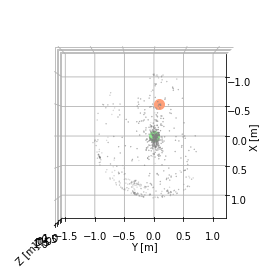

In [21]:
traj.create_plot()

In [ ]:
traj.create_plot()